# Bài tập nhóm lần 2 (Bản nộp lại)

Thành viên:
- 23C24004 - Lê Nhựt Nam
- 23C24005 - Phạm Thừa Tiểu Thành

Phân công công việc
- Thành -> xử lý đa cộng tuyến, mô hình mpg, boston
- Nam -> trực quan, trình bày, lựa chọn mô hình tốt nhất mpg, boston

## Import

In [1]:
library(dplyr)
library(tidyr)
library(car)
library(MASS)
library(leaps)
library(Metrics)
library(lmtest)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Hàm phụ trợ

In [2]:
remove_high_vif <- function(regr_variable, data, threshold = 5) {  
    library(car)
    library(dplyr)
    
    stop <- FALSE
    while(stop == FALSE) {
        # Tính VIF cho các biến độc lập
        model <- lm(as.formula(paste(regr_variable, "~ .")), data = data)
        vif_values <- vif(model)
        # Tìm các biến có VIF cao hơn ngưỡng
        high_vif <- which(vif_values > threshold)
        
        if (length(high_vif) > 0) {
            # Loại bỏ các biến có VIF cao
            remove_index <- which.max(high_vif)
            rm_names <- names(data[, !names(data) %in% regr_variable])
            rm_name <- rm_names[remove_index]
            data <- data[, !names(data) %in% rm_name]
        } else {
            stop <- TRUE
        }
    }
    return(data)
}

## Đọc dữ liệu

In [3]:
# Đọc dữ liệu từ tập tin
raw_data = read.table("./data/Boston.csv", header=TRUE, sep=",", stringsAsFactors = FALSE)
str(raw_data)

'data.frame':	506 obs. of  15 variables:
 $ X      : int  1 2 3 4 5 6 7 8 9 10 ...
 $ crim   : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ zn     : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ indus  : num  2.31 7.07 7.07 2.18 2.18 2.18 7.87 7.87 7.87 7.87 ...
 $ chas   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nox    : num  0.538 0.469 0.469 0.458 0.458 0.458 0.524 0.524 0.524 0.524 ...
 $ rm     : num  6.58 6.42 7.18 7 7.15 ...
 $ age    : num  65.2 78.9 61.1 45.8 54.2 58.7 66.6 96.1 100 85.9 ...
 $ dis    : num  4.09 4.97 4.97 6.06 6.06 ...
 $ rad    : int  1 2 2 3 3 3 5 5 5 5 ...
 $ tax    : int  296 242 242 222 222 222 311 311 311 311 ...
 $ ptratio: num  15.3 17.8 17.8 18.7 18.7 18.7 15.2 15.2 15.2 15.2 ...
 $ black  : num  397 397 393 395 397 ...
 $ lstat  : num  4.98 9.14 4.03 2.94 5.33 ...
 $ medv   : num  24 21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 ...


In [4]:
# remove cột đầu vì đó là cột số thứ tự
raw_data = raw_data[, -1]

## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [5]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 506 dòng và 14 cột
dim(raw_data)

[1] 506  14

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [6]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- table(raw_data[duplicated(raw_data), ])
duplicates # Không có dữ liệu trùng lặp

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>


### Mỗi cột mang ý nghĩa gì?

In [7]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

'data.frame':	506 obs. of  14 variables:
 $ crim   : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ zn     : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ indus  : num  2.31 7.07 7.07 2.18 2.18 2.18 7.87 7.87 7.87 7.87 ...
 $ chas   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nox    : num  0.538 0.469 0.469 0.458 0.458 0.458 0.524 0.524 0.524 0.524 ...
 $ rm     : num  6.58 6.42 7.18 7 7.15 ...
 $ age    : num  65.2 78.9 61.1 45.8 54.2 58.7 66.6 96.1 100 85.9 ...
 $ dis    : num  4.09 4.97 4.97 6.06 6.06 ...
 $ rad    : int  1 2 2 3 3 3 5 5 5 5 ...
 $ tax    : int  296 242 242 222 222 222 311 311 311 311 ...
 $ ptratio: num  15.3 17.8 17.8 18.7 18.7 18.7 15.2 15.2 15.2 15.2 ...
 $ black  : num  397 397 393 395 397 ...
 $ lstat  : num  4.98 9.14 4.03 2.94 5.33 ...
 $ medv   : num  24 21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 ...


Thông tin các biến trong dữ liệu như sau:
- crim (numerical, continuous): tỷ lệ tội phạm bình quân đầu người theo thị trấn
- zn (numerical, continuous): tỷ lệ đất ở được quy hoạch cho các lô có diện tích trên 25.000 m2.
- indus (numerical, continuous): tỷ lệ diện tích kinh doanh phi bán lẻ trên mỗi thị trấn.
- chas (categorical, nominal): Sông Charles (= 1 nếu đường giáp sông; 0 nếu không) (biến giả - dummy variable).
- nox (numerical, continuous): nồng độ oxit nitơ (phần trên 10 triệu).
- rm (numerical, continuous): số phòng trung bình cho mỗi nhà ở.
- age (numerical, continuous): tỷ lệ các căn hộ do chủ sở hữu sử dụng được xây dựng trước năm 1940.
- dis (numerical, continuous): khoảng cách trung bình có trọng số đến năm trung tâm việc làm ở Boston.
- rad (categorical, ordinal): chỉ số khả năng tiếp cận các đường cao tốc hướng tâm. chỉ số lớn hơn biểu thị khả năng tiếp cận tốt hơn.
- tax (numerical, continuous): mức thuế tài sản có giá trị đầy đủ trên 10.000 USD.
- ptratio (numerical, continuous): tỷ lệ học sinh-giáo viên theo thị trấn.
- black (numerical, continuous): $1000 (Bk - 0.63)^2$ trong đó $Bk$ là tỷ lệ người da đen theo thị trấn.
- lstat (numerical, continuous): địa vị thấp hơn của dân số (phần trăm)
- medv (numerical, continuous): giá trị trung bình của những ngôi nhà do chủ sở hữu sử dụng tính bằng $1000

### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

In [8]:
raw_data$chas <- as.character(raw_data$chas)
raw_data$rad <- as.character(raw_data$rad)

### Các cột với kiểu dữ liệu số phân bố như thế nào?

In [9]:
# Function to calculate missing ratio
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

In [10]:
# Function to calculate median
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

In [11]:
# Function to calculate lower quartile
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

In [12]:
# Function to calculate upper quartile
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [13]:
# Select numerical columns
num_col_info_df <- as.data.frame(raw_data)  %>%
  select_if(is.numeric)

# Aggregating statistics
num_col_info_df <- num_col_info_df %>%
  reframe(
    missing_ratio = sapply(., missing_ratio),
    min = sapply(., min, na.rm = TRUE),
    lower_quartile = sapply(., lower_quartile),
    median = sapply(., median_custom),
    upper_quartile = sapply(., upper_quartile),
    max = sapply(., max, na.rm = TRUE)
  )

  print(num_col_info_df)

   missing_ratio       min lower_quartile median upper_quartile      max
1              0   0.00632            0.1    0.3            3.7  88.9762
2              0   0.00000            0.0    0.0           12.5 100.0000
3              0   0.46000            5.2    9.7           18.1  27.7400
4              0   0.38500            0.4    0.5            0.6   0.8710
5              0   3.56100            5.9    6.2            6.6   8.7800
6              0   2.90000           45.0   77.5           94.1 100.0000
7              0   1.12960            2.1    3.2            5.2  12.1265
8              0 187.00000          279.0  330.0          666.0 711.0000
9              0  12.60000           17.4   19.0           20.2  22.0000
10             0   0.32000          375.4  391.4          396.2 396.9000
11             0   1.73000            6.9   11.4           17.0  37.9700
12             0   5.00000           17.0   21.2           25.0  50.0000


Ta không thấy có missing values nào cả.

In [14]:
df <- raw_data

### Các cột với kiểu dữ liệu phân loại phân bố như thế nào?

In [15]:
# Function to calculate missing ratio
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

In [16]:
# Function to calculate number of unique values
num_values <- function(s) {
  s <- strsplit(s, ";")
  s <- unlist(s)
  length(unique(s))
}

In [17]:
# Function to calculate value ratios
value_ratios <- function(s) {
  s <- strsplit(s, ";")
  s <- unlist(s)
  totalCount <- sum(!is.na(s))
  value_counts <- table(s)
  ratios <- round((value_counts / totalCount) * 100, 1)
  as.list(ratios)
}

In [18]:
# Select categorical columns (assuming character columns as categorical)
cat_col_info_df <-  df[,c("chas", "rad")]  %>%
  select_if(is.character)

# Function to aggregate results for each column
aggregate_results <- function(df) {
  result <- data.frame(
    column = names(df),
    missing_ratio = sapply(df, missing_ratio),
    num_values = sapply(df, num_values),
    value_ratios = I(lapply(df, value_ratios))
  )
  result
}

# Apply the aggregation function
cat_col_info_df <- aggregate_results(cat_col_info_df)

# Print the result
print(cat_col_info_df)

     column missing_ratio num_values value_ratios
chas   chas             0          2    93.1, 6.9
rad     rad             0          9 4, 4.7, ....


Ta cũng không thấy missing value nào ở đây cả.

In [19]:
df$chas <- as.integer(df$chas)
df$rad <- as.integer(df$rad)

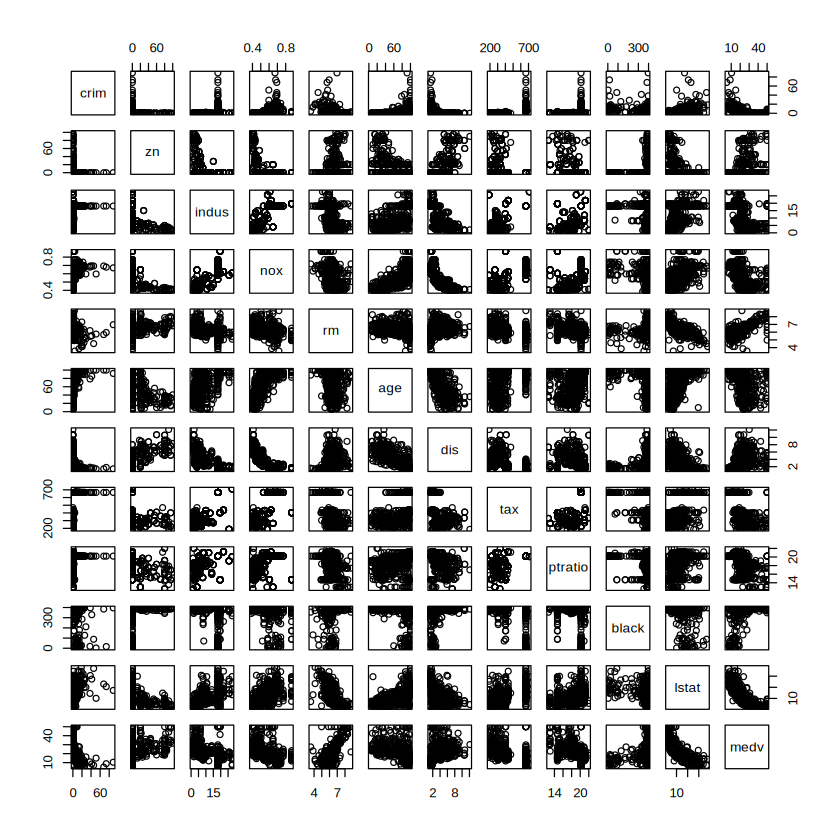

In [20]:
# Trực quan dữ liệu
plot(df[,!(names(df) %in% c("rad","chas"))])

In [21]:
names(df) 

[1] "crim"    "zn"      "indus"   "chas"    "nox"     "rm"      "age"    
 [8] "dis"     "rad"     "tax"     "ptratio" "black"   "lstat"   "medv"

In [22]:
round(cor(df[,!(names(df) %in% c("rad","chas"))]),2)

,crim,zn,indus,nox,rm,age,dis,tax,ptratio,black,lstat,medv
crim,1.00,-0.20,0.41,0.42,-0.22,0.35,-0.38,0.58,0.29,-0.39,0.46,-0.39
zn,-0.20,1.00,-0.53,-0.52,0.31,-0.57,0.66,-0.31,-0.39,0.18,-0.41,0.36
indus,0.41,-0.53,1.00,0.76,-0.39,0.64,-0.71,0.72,0.38,-0.36,0.60,-0.48
nox,0.42,-0.52,0.76,1.00,-0.30,0.73,-0.77,0.67,0.19,-0.38,0.59,-0.43
rm,-0.22,0.31,-0.39,-0.30,1.00,-0.24,0.21,-0.29,-0.36,0.13,-0.61,0.70
age,0.35,-0.57,0.64,0.73,-0.24,1.00,-0.75,0.51,0.26,-0.27,0.60,-0.38
dis,-0.38,0.66,-0.71,-0.77,0.21,-0.75,1.00,-0.53,-0.23,0.29,-0.50,0.25
tax,0.58,-0.31,0.72,0.67,-0.29,0.51,-0.53,1.00,0.46,-0.44,0.54,-0.47
ptratio,0.29,-0.39,0.38,0.19,-0.36,0.26,-0.23,0.46,1.00,-0.18,0.37,-0.51
black,-0.39,0.18,-0.36,-0.38,0.13,-0.27,0.29,-0.44,-0.18,1.00,-0.37,0.33


Dựa bên ma trận tương quan, ta có thể thấy được sự ảnh hưởng của các biến đối với biến medv. Ví dụ:
- Các biến lstat, ptratio có tương quan nghịch với biến medv
- Các biến black có tương quan thuận với biến medv

Bên cạnh đó, ma trận tương quan cũng cho ta các insight về việc giữa các biến có mối liên hệ gì với nhau hay không. Ví dụ:
- Giữa tax và indus có mối liên hệ cao (0.72), điều này nói lên rằng mức thuế tài sản tỷ lệ thuận với diện tích kinh doanh phi bán lẻ trong thị trấn.

In [23]:
# factor biến giả
df$chas = as.factor(df$chas)

### Khảo sát ngoại lai

In [24]:
# Function to identify and remove outliers using Cook's distance
identify_and_remove_outliers_cooks <- function(df, model) {
  # Check if the dataframe and model are provided
  if (!is.data.frame(df)) {
    stop("Input 'df' must be a dataframe")
  }
  if (!inherits(model, "lm")) {
    stop("Input 'model' must be a linear regression model (lm)")
  }
  
  # Obtain Cook's distance
  cooks_dist <- cooks.distance(model)
  
  # Find outliers based on a threshold
  outlier_threshold <- 4 / nrow(df) # Adjust the threshold as needed
  outliers <- which(cooks_dist > outlier_threshold)
  
  # Remove outliers from the dataframe
  df_cleaned <- df[-outliers, ]
  
  # Print Cook's distance and identified outliers
  cat("Cook's distance:\n")
  print(cooks_dist)
  cat("\nIdentified outliers:\n")
  print(outliers)
  
  return(df_cleaned)
}

model <- lm(medv ~ ., data = df)
df<- identify_and_remove_outliers_cooks(df, model)

Cook's distance:
           1            2            3            4            5            6 
2.002412e-03 4.228574e-04 6.558535e-04 1.180581e-03 3.598514e-03 5.741947e-04 
           7            8            9           10           11           12 
4.725468e-07 5.826354e-03 4.629940e-03 4.013832e-08 1.926403e-03 5.674596e-04 
          13           14           15           16           17           18 
3.624082e-05 3.225870e-05 5.588111e-05 1.656261e-05 4.912073e-04 1.324908e-05 
          19           20           21           22           23           24 
1.273985e-03 1.695813e-06 6.972224e-05 1.609478e-04 2.077964e-05 2.906886e-05 
          25           26           27           28           29           30 
3.110141e-07 1.383891e-05 6.483885e-05 4.413623e-07 7.334857e-05 7.627960e-07 
          31           32           33           34           35           36 
9.895472e-05 7.464071e-04 2.280544e-03 7.203168e-05 3.221152e-06 7.688543e-04 
          37           38          

## Xử lý đa cộng tuyến

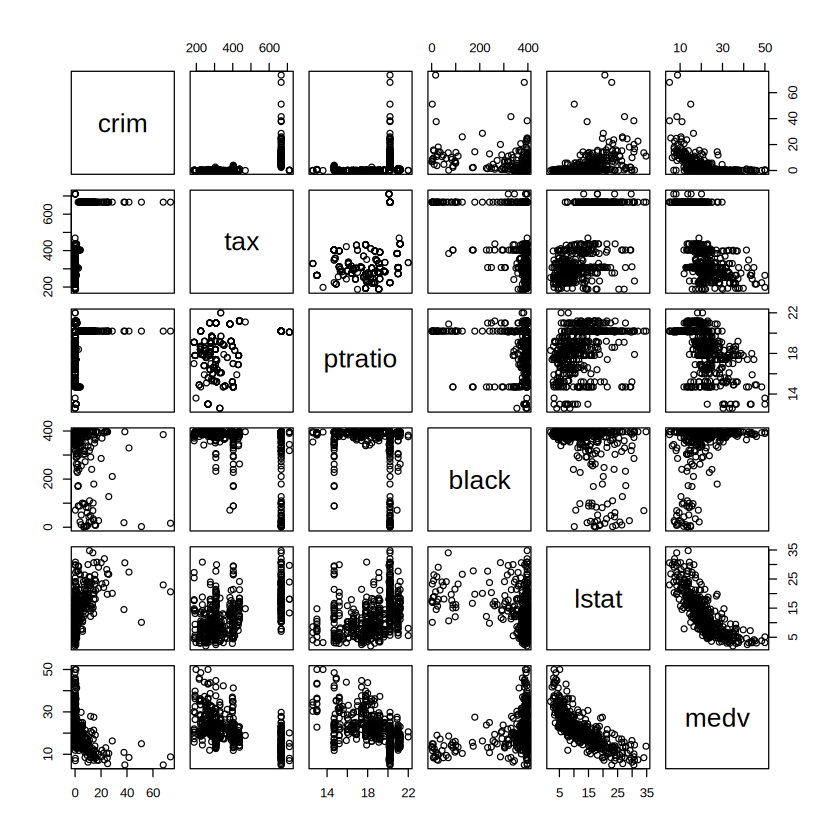

In [25]:
# Gọi hàm xử lý đa cộng tuyến
cleaned_df = remove_high_vif("medv", df,threshold = 5)
plot(cleaned_df)

Sau khi thực hiện xử lý đa cộng tuyến dựa trên VIF, ta thu được dữ liệu gồm 5 biến: crim, tax, ptratio, black, và lstat

In [26]:
# Xem một số quan trắc
str(cleaned_df)

'data.frame':	476 obs. of  6 variables:
 $ crim   : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ tax    : int  296 242 242 222 222 222 311 311 311 311 ...
 $ ptratio: num  15.3 17.8 17.8 18.7 18.7 18.7 15.2 15.2 15.2 15.2 ...
 $ black  : num  397 397 393 395 397 ...
 $ lstat  : num  4.98 9.14 4.03 2.94 5.33 ...
 $ medv   : num  24 21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 ...


## Phân chia tập dữ liệu

In [27]:
n = nrow(cleaned_df)
train_indices <- sample(seq_len(n), size = 0.7 * n)
train = cleaned_df[train_indices,]
test = cleaned_df[-train_indices,]

In [28]:
# số chiều tập train
dim(train)

[1] 333   6

In [29]:
# số chiều tập test
dim(test)

[1] 143   6

In [30]:
# xem một số quan trắc của tập train
str(train)

'data.frame':	333 obs. of  6 variables:
 $ crim   : num  0.7842 15.5757 5.4411 15.0234 0.0647 ...
 $ tax    : int  307 666 666 666 358 304 329 666 296 666 ...
 $ ptratio: num  21 20.2 20.2 20.2 14.8 18.4 12.6 20.2 15.3 20.2 ...
 $ black  : num  387 369 355 349 368 ...
 $ lstat  : num  14.67 18.13 17.73 24.91 4.97 ...
 $ medv   : num  17.5 19.1 15.2 12 22.5 21 30.3 19.6 24 23 ...


## Khớp mô hình và lựa chọn model tốt nhất với step

In [31]:
model = lm(medv~., data=train)
model_best <- step(model, direction = "both",trace = FALSE)

In [32]:
# Tóm tắt mô hình
print(summary(model_best))


Call:
lm(formula = medv ~ tax + ptratio + black + lstat, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.5437  -2.9961  -0.3377   2.1262  16.6881 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 48.239429   2.578088  18.711  < 2e-16 ***
tax         -0.003195   0.002085  -1.533   0.1263    
ptratio     -0.987332   0.133190  -7.413 1.06e-12 ***
black        0.006249   0.003070   2.036   0.0426 *  
lstat       -0.719488   0.049178 -14.630  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.542 on 328 degrees of freedom
Multiple R-squared:  0.6803,	Adjusted R-squared:  0.6764 
F-statistic: 174.5 on 4 and 328 DF,  p-value: < 2.2e-16



Ta thấy biến tax, và crim không có ý nghĩa nên sẽ bỏ nó đi.

In [33]:
model = lm(medv~., data=train[,!(names(train) %in% c("tax", "crim"))])
model_best <- step(model, direction = "both",trace = FALSE)

In [34]:
# Tóm tắt mô hình
print(summary(model_best))


Call:
lm(formula = medv ~ ptratio + black + lstat, data = train[, !(names(train) %in% 
    c("tax", "crim"))])

Residuals:
     Min       1Q   Median       3Q      Max 
-11.1731  -2.9060  -0.3877   2.0275  16.5085 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 48.034711   2.579900  18.619  < 2e-16 ***
ptratio     -1.049573   0.127108  -8.257 3.67e-15 ***
black        0.007578   0.002950   2.569   0.0107 *  
lstat       -0.752346   0.044350 -16.964  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.552 on 329 degrees of freedom
Multiple R-squared:  0.678,	Adjusted R-squared:  0.675 
F-statistic: 230.9 on 3 and 329 DF,  p-value: < 2.2e-16



In [35]:
print(model_best$coefficients)

 (Intercept)      ptratio        black        lstat 
48.034711466 -1.049572801  0.007578373 -0.752345933 


### Phân tích kết quả

Từ kết quả này ta có công thức ước lượng hồi quy như sau:

`medv = 44.942764600 -0.863476785 * ptratio +0.006398789 * black -0.761905614  * lstat`

Điều này có nghĩa là giá trị trung bình của một căn nhà giảm nếu ở khu vực đó có tỷ lệ học sinh - giáo viên cao, hoặc nếu ở đó vị trí tầng lớp của dân cư thấp. Hơn nữa, tỷ lệ người da màu cũng ảnh hưởng đến giá trị trung bình của căn nhà. Theo đó, nếu khu vực đó có tỷ lệ người da màu tăng thì giá căn nhà tăng (nhưng không đáng kể, bởi vì hệ số này thấp, có vẻ là do chính sách bình đẳng chủng tộc?)

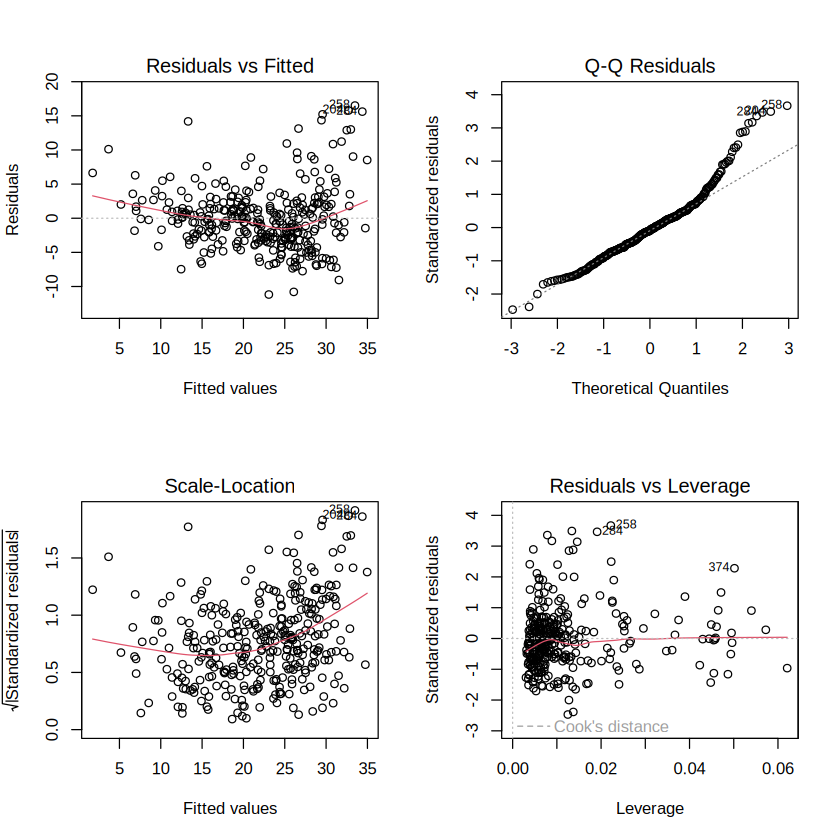

In [36]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(model_best)

#### Residuals vs Fitted Plot

Biểu đồ **Residuals vs Fitted Plot** đưa ra dấu hiệu nếu có các mẫu phi tuyến tính. Để hồi quy tuyến tính chính xác, dữ liệu cần phải tuyến tính nên điều này sẽ kiểm tra xem điều kiện đó có được đáp ứng hay không.

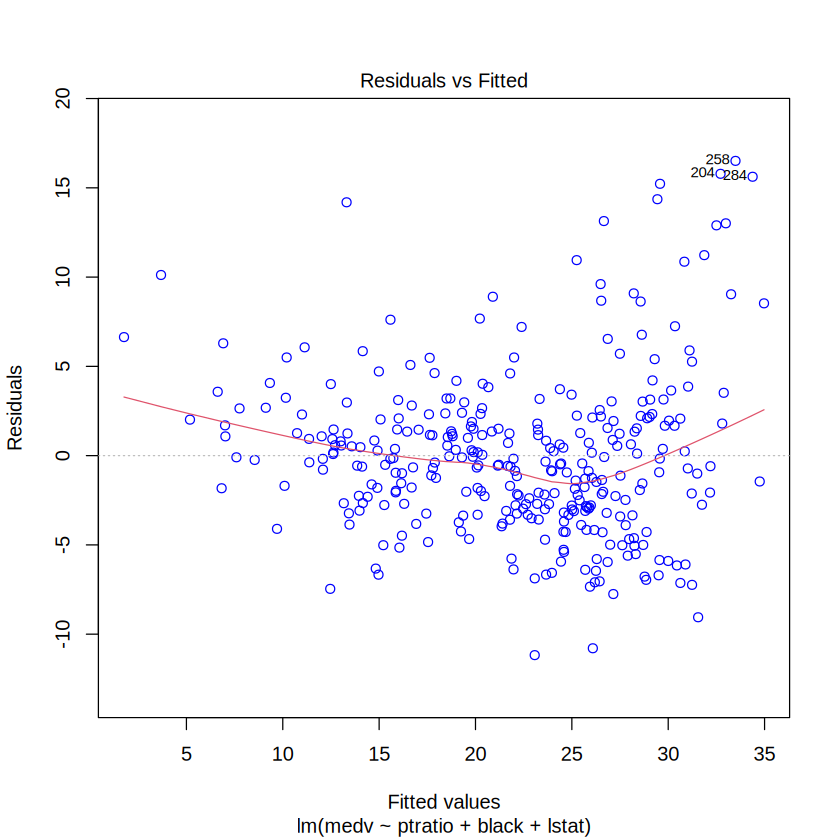

In [37]:
plot(model_best, which=1, col=c("blue")) # Residuals vs Fitted Plot

Như kết quả từ biểu đồ, ta thấy dáng của đường màu đỏ chưa gần như một đường thẳng và có xu hướng lệch về phía bên dưới của biểu đồ. Điều này thể hiện có tồn tại mối quan hệ phi tuyến trong dữ liệu.

#### Normal Q–Q (quantile-quantile) Plot

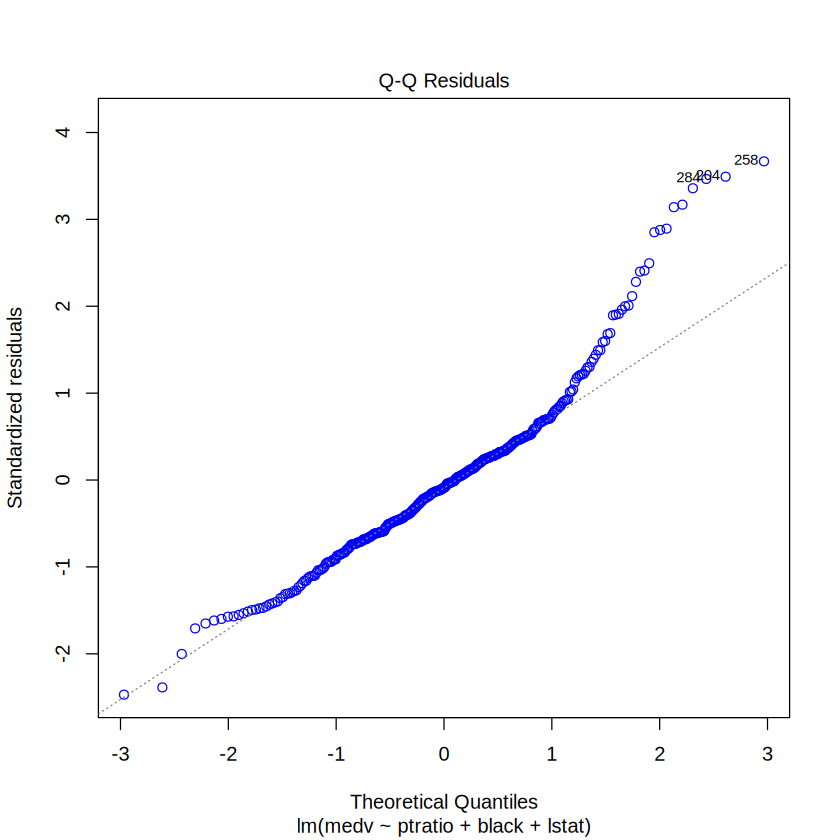

In [38]:
plot(model_best, which=2, col=c("blue")) # QQ Plot

Các giá trị thặng dư (residual) nên có phân phối chuẩn. Để kiểm tra điều này, chúng ta cần quan sát biểu đồ QQ Residuals plot, nếu các điểm được xếp thành một đường thẳng (hoặc gần như thẳng) thì chứng tỏ các giá trị thặng dư (residual) có phân phối chuẩn. Như hình vẽ kết quả ở trên, ta thấy rõ điều đó, residual chưa có phân phối chuẩn.

Cẩn thận hơn, chúng ta thử dùng Shapiro–Wilk test để kiểm tra có đúng thật là các giá trị thặng dư có phân phối chuẩn hay không?
- H0: Biến thặng dư của mô hình phân phối chuẩn trong một số quần thể.
- H1: Biến thặng dư của mô hình không phân phối chuẩn trong một số quần thể.

In [39]:
shapiro.test(residuals(model_best))


	Shapiro-Wilk normality test

data:  residuals(model_best)
W = 0.94732, p-value = 1.582e-09


Kết quả cho thấy p-value bé hơn mức ý nghĩa alpha 0.05 nên ta chưa có thể bác bỏ giả thhuyết H0, biến thặng dư của chúng ta chuẩn trong một số quần thể. 

#### Scale-Location

Biểu đồ scale-location kiểm định giả định hồi quy về phương sai bằng nhau (homoscedasticity), tức là giá trị thặng dư có phương sai bằng với đường hồi quy.

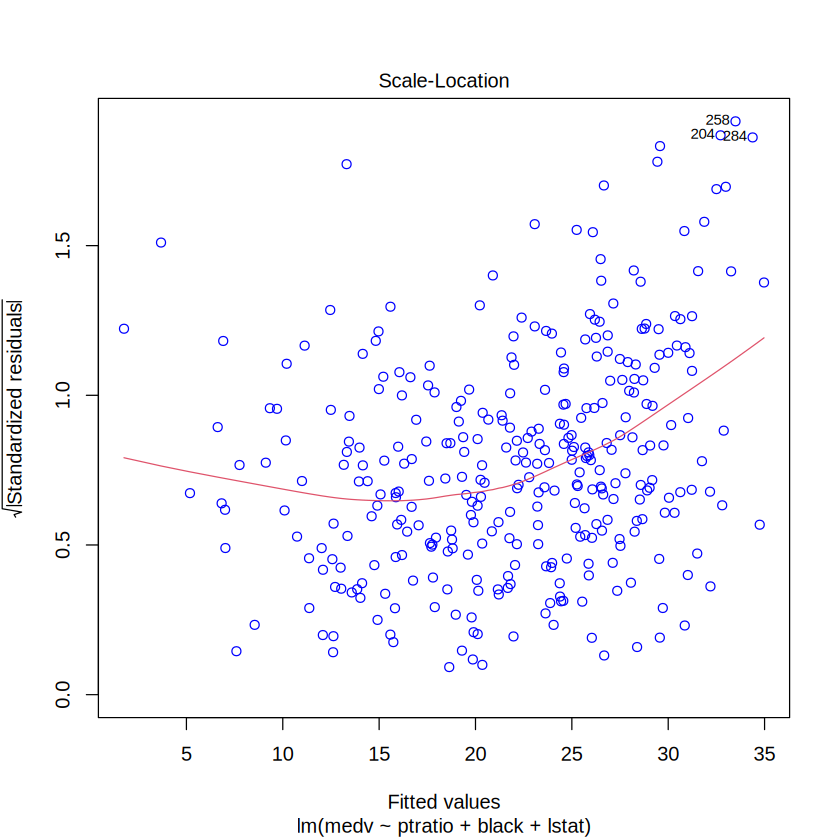

In [40]:
plot(model_best, which=3, col=c("blue")) # Scale-Location

Ta phát hiện:
- Đường màu đỏ gần như không nằm ngang trên biểu đồ. Nếu đúng như vậy thì giả định về tính đồng nhất chưa được thỏa mãn đối với mô hình hồi quy đã cho. Nghĩa là, độ phân tán của giá trị thặng dư gần chưa bằng nhau ở tất cả các giá trị phù hợp.

Cẩn thận hơn, chúng ta sử dụng Breusch-Pagan test để kiểm tra có thật là như vậy không?
- H0: Các giá trị thặng dư là homoscedastic
- H1: Các giá trị thặng dư là heteroscedastic

In [41]:
# Breusch-Pagan Test
bptest(model_best)


	studentized Breusch-Pagan test

data:  model_best
BP = 34.355, df = 3, p-value = 1.667e-07


Như vậy, ta thấy p-value bé hơn múc ý nghĩa 0.05 rất nhiều, ta chưa đủ điều kiện bác bỏ H0. Vậy các giá trị thặng dư là homoscedastic

#### Residuals vs Leverage

Biểu đồ này có thể được sử dụng để tìm các trường hợp có ảnh hưởng trong tập dữ liệu. Một trường hợp có ảnh hưởng là một trường hợp mà nếu bị loại bỏ sẽ ảnh hưởng đến mô hình nên việc đưa vào hoặc loại trừ nó cần được xem xét.

Một trường hợp có ảnh hưởng có thể là một trường hợp ngoại lệ hoặc không và mục đích của biểu đồ này là xác định các trường hợp có ảnh hưởng lớn đến mô hình. Các ngoại lệ sẽ có xu hướng có giá trị cực cao hoặc cực thấp và do đó ảnh hưởng đến mô hình.

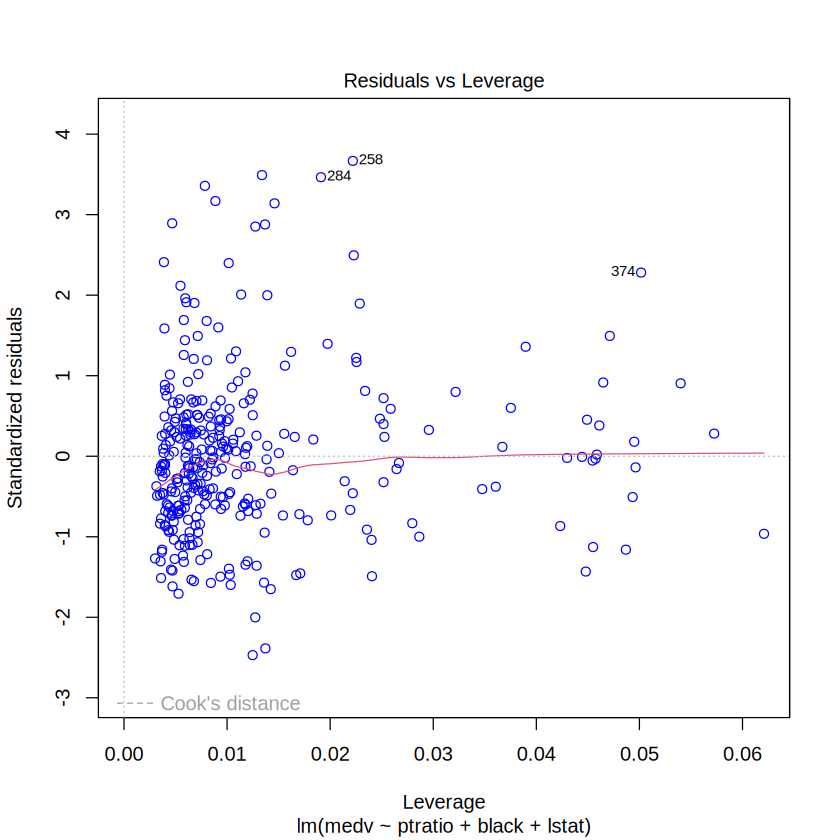

In [42]:
plot(model_best, which=5, col=c("blue"))  # Residuals vs Leverage

Ta nhận thấy có một số giá trị ngoại lai ở cách xa đường thằng giữa. Ta có thể xem rõ hơn thông qua histogram của Cook's Distance

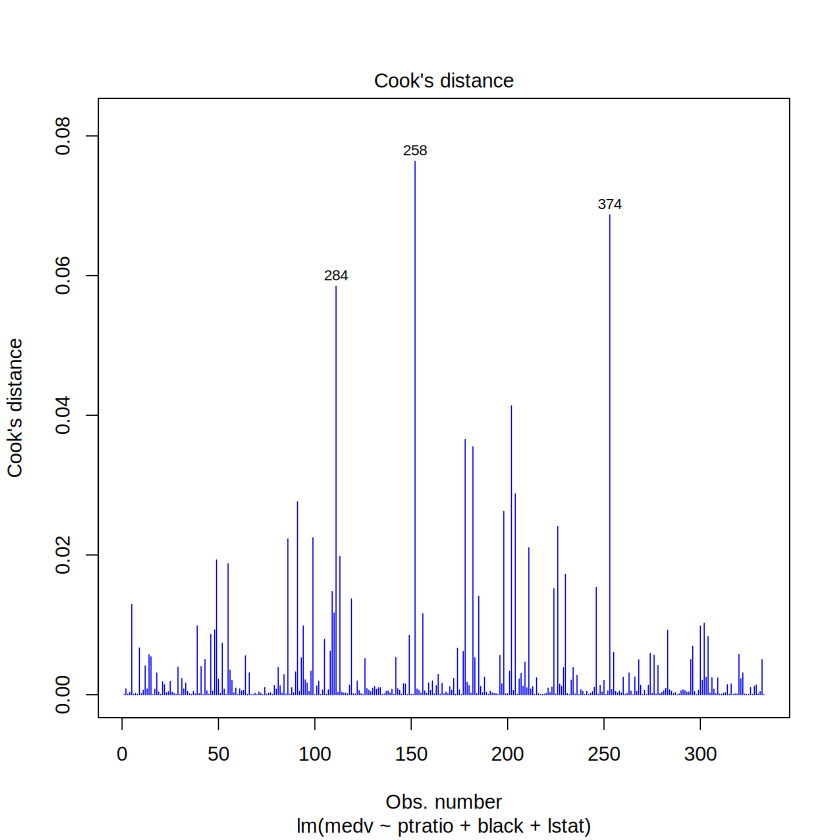

In [43]:
plot(model_best, which=4, col=c("blue"))  # Cook's Distance

### Dự đoán và đánh giá kết quả

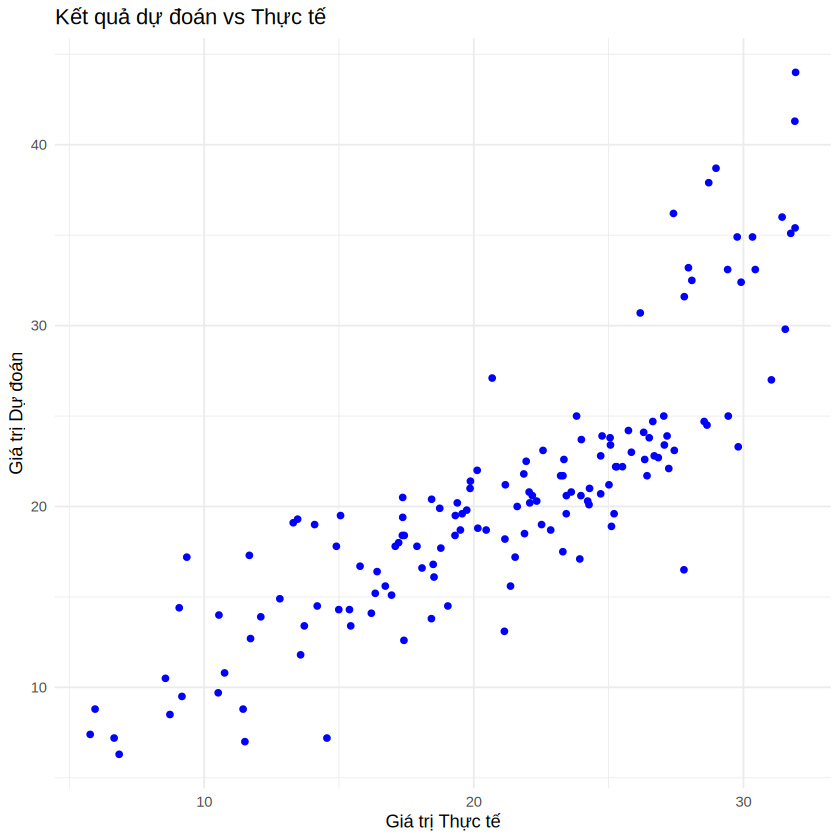

In [44]:
# predict
results <- predict(model_best, test)
df <- data.frame(
    du_doan <- results,
    label <- test$medv
)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

Tính toán RMSE của mô hình

In [45]:
rmse(results, test$medv)

[1] 3.856846

## Khớp mô hình và lựa chọn model tốt nhất với leaps

Tìm kiếm mô hình tốt nhất bằng regsubsets mà leaps cung cấp

In [46]:
models <- regsubsets(medv~., data =train, nvmax = 5, method = "seqrep")

In [47]:
print(summary(models))

Subset selection object
Call: regsubsets.formula(medv ~ ., data = train, nvmax = 5, method = "seqrep")
5 Variables  (and intercept)
        Forced in Forced out
crim        FALSE      FALSE
tax         FALSE      FALSE
ptratio     FALSE      FALSE
black       FALSE      FALSE
lstat       FALSE      FALSE
1 subsets of each size up to 5
Selection Algorithm: 'sequential replacement'
         crim tax ptratio black lstat
1  ( 1 ) " "  " " " "     " "   "*"  
2  ( 1 ) " "  " " "*"     " "   "*"  
3  ( 1 ) " "  " " "*"     "*"   "*"  
4  ( 1 ) " "  "*" "*"     "*"   "*"  
5  ( 1 ) "*"  "*" "*"     "*"   "*"  


Các dấu sao (*) ở cuối kết quả đầu ra cho biết biến dự đoán nào thuộc mô hình hồi quy tốt nhất cho từng mô hình có thể có với số lượng biến dự đoán khác nhau.

- Đối với mô hình chỉ có một biến dự đoán, mô hình hồi quy tốt nhất được tạo ra bằng cách sử dụng lstat làm biến dự đoán.

- Đối với mô hình có hai biến dự đoán, mô hình hồi quy tốt nhất được tạo ra bằng cách sử dụng lstat và ptratio làm biến dự đoán.

- Đối với mô hình có ba biến dự đoán, mô hình hồi quy tốt nhất được tạo ra bằng cách sử dụng lstat, ptratio và tax làm biến dự đoán.

- Đối với mô hình có bốn biến dự đoán, mô hình hồi quy tốt nhất được tạo ra bằng cách sử dụng lstat, ptratio, tax và black làm biến dự đoán.
- Đối với mô hình có năm biến dự đoán, mô hình hồi quy tốt nhất được tạo ra bằng cách sử dụng lstat, ptratio, tax, black và crim làm biến dự đoán.

In [48]:
models_summary <- summary(models)
models_summary$which

,(Intercept),crim,tax,ptratio,black,lstat
1,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE
2,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE
3,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE
4,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE
5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


Xem xét chỉ số cp

In [49]:
# Chỉ số cp
print(models_summary $cp)

[1] 78.223752  9.803361  5.181897  4.833889  6.000000


- Giá trị CP cho mô hình với một biến dự đoán là `91.963027`.
- Giá trị CP cho mô hình với hai biến dự đoán là `19.957270`.
- Giá trị CP cho mô hình với ba biến dự đoán là `8.228702`.
- Giá trị CP cho mô hình với bốn biến dự đoán là `4.934792`.
- Giá trị CP cho mô hình với nắm biến dự đoán là `6.000000`.

Xem xét chỉ số R-hiệu chỉnh

In [50]:
print(models_summary$adjr2)

[1] 0.6016319 0.6695225 0.6750348 0.6763620 0.6761980


- Giá trị bình phương R hiệu chỉnh cho mô hình với một biến dự đoán là `0.6090059`
- Giá trị bình phương R hiệu chỉnh cho mô hình với hai biến dự đoán là `0.6767666`
- Giá trị bình phương R hiệu chỉnh cho mô hình với ba biến dự đoán là `0.6886128`
- Giá trị bình phương R hiệu chỉnh cho mô hình với bốn biến dự đoán là `0.6926255`
- Giá trị bình phương R hiệu chỉnh cho mô hình với năm biến dự đoán là `0.6925644`

In [51]:
# Xem xét chỉ số BIC
print(models_summary $bic)

[1] -295.8744 -353.2908 -354.0945 -350.6629 -345.7029


- Giá trị BIC cho mô hình với một biến dự đoán là `-302.0962`
- Giá trị BIC cho mô hình với hai biến dự đoán là `-360.6714`
- Giá trị BIC cho mô hình với ba biến dự đoán là `-368.3073`
- Giá trị BIC cho mô hình với bốn biến dự đoán là `-367.8319`
- Giá trị BIC cho mô hình với năm biến dự đoán là `-362.9744`

Bây giờ, ta lựa chọn mô hình tốt nhất có Bayesian Information Criterion (BIC) nhỏ nhất

In [52]:
best_model_index <- which.min(models_summary$bic)
best_model <- models_summary$which[best_model_index, ]
print(best_model)
best_vars <- names(best_model[best_model])
best_vars <- best_vars[best_vars != "(Intercept)"]
print(best_vars)

(Intercept)        crim         tax     ptratio       black       lstat 
       TRUE       FALSE       FALSE        TRUE        TRUE        TRUE 
[1] "ptratio" "black"   "lstat"  


In [53]:
# Xây dựng mô hình tốt nhất
formula_str <- paste("medv ~", paste(best_vars, collapse = " + "))
best_model_lm <- lm(as.formula(formula_str), data=train)

In [54]:
# Xem tóm tắt của mô hình tốt nhất
summary(best_model_lm)


Call:
lm(formula = as.formula(formula_str), data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.1731  -2.9060  -0.3877   2.0275  16.5085 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 48.034711   2.579900  18.619  < 2e-16 ***
ptratio     -1.049573   0.127108  -8.257 3.67e-15 ***
black        0.007578   0.002950   2.569   0.0107 *  
lstat       -0.752346   0.044350 -16.964  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.552 on 329 degrees of freedom
Multiple R-squared:  0.678,	Adjusted R-squared:  0.675 
F-statistic: 230.9 on 3 and 329 DF,  p-value: < 2.2e-16


In [55]:
print(best_model_lm$coefficients)

 (Intercept)      ptratio        black        lstat 
48.034711466 -1.049572801  0.007578373 -0.752345933 


### Phân tích kết quả

Từ kết quả này ta có công thức ước lượng hồi quy như sau:

`medv = 50.057347137 - 0.932353723 * ptratio -0.719384271   * lstat - 0.004908431 * tax`

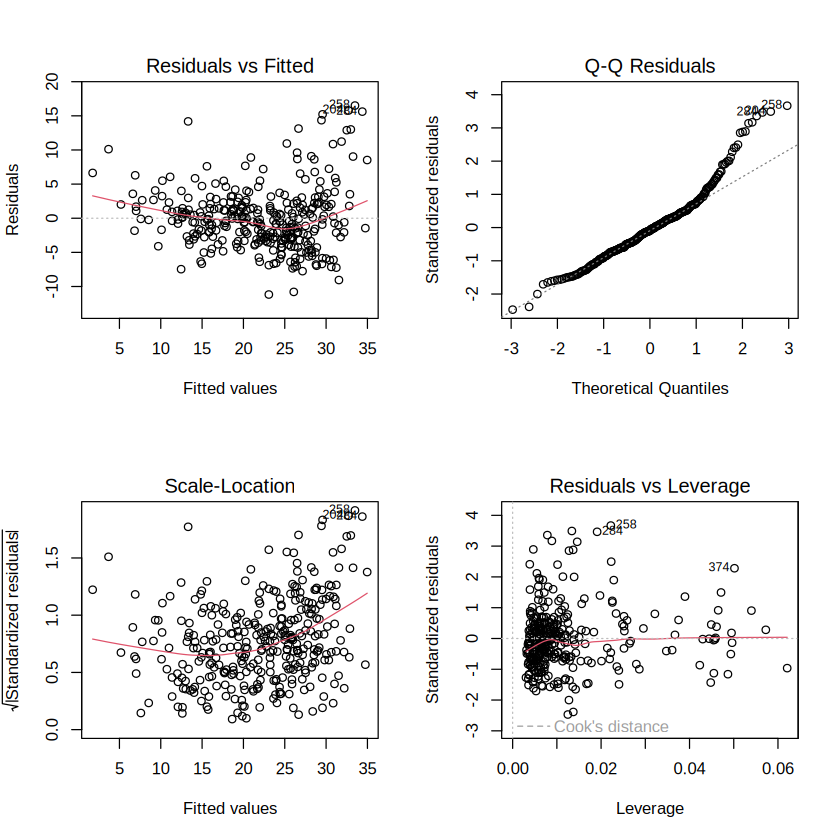

In [56]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(best_model_lm)

#### Residuals vs Fitted Plot

Biểu đồ **Residuals vs Fitted Plot** đưa ra dấu hiệu nếu có các mẫu phi tuyến tính. Để hồi quy tuyến tính chính xác, dữ liệu cần phải tuyến tính nên điều này sẽ kiểm tra xem điều kiện đó có được đáp ứng hay không.

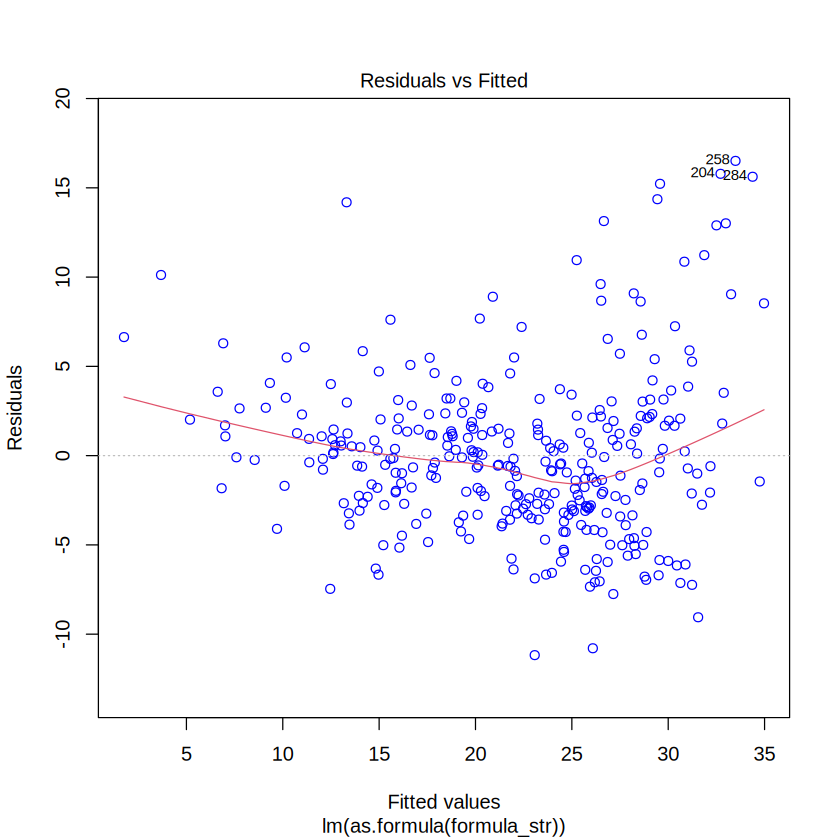

In [57]:
plot(best_model_lm, which=1, col=c("blue")) # Residuals vs Fitted Plot

Dựa trên biểu đồ này, ta thấy đường cong màu đỏ có dáng chưa gần như một đường thẳng, và các phần tử trải dọc theo đường cong này một cách tương chưa đồng đều. Điều này chứng tỏ có quan hệ phi tuyến xuất hiện trong dữ liệu.

#### Normal Q–Q (quantile-quantile) Plot

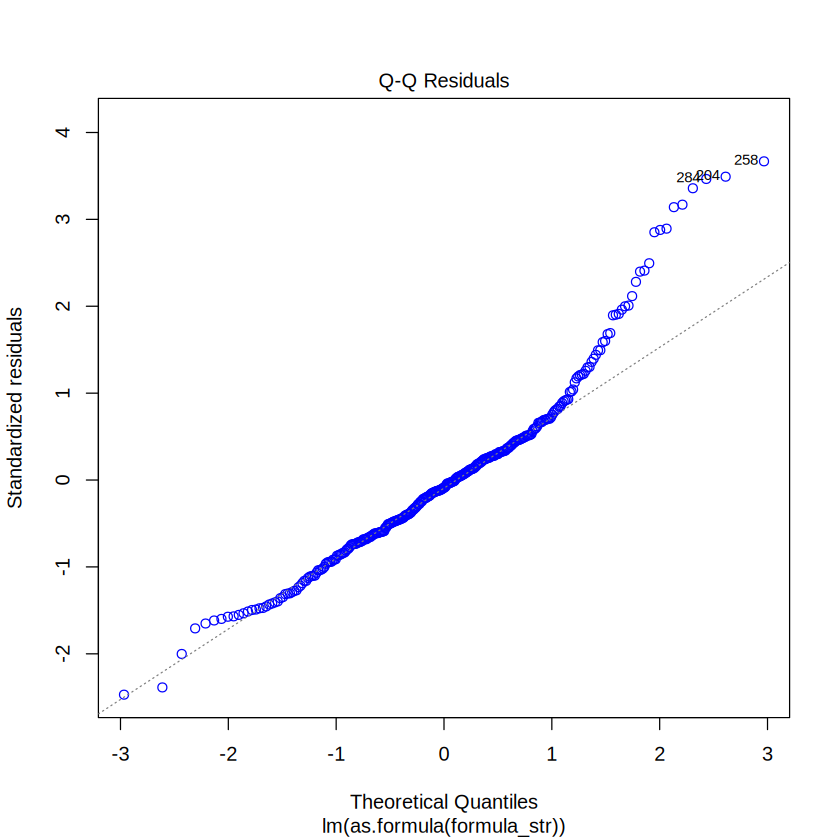

In [58]:
plot(best_model_lm, which=2, col=c("blue")) # QQ Plot

Các giá trị thặng dư (residual) nên có phân phối chuẩn. Để kiểm tra điều này, chúng ta cần quan sát biểu đồ QQ Residuals plot, nếu các điểm được xếp thành một đường thẳng (hoặc gần như thẳng) thì chứng tỏ các giá trị thặng dư (residual) có phân phối chuẩn. Như hình vẽ kết quả ở trên, ta thấy rõ điều đó, residual có phân phối chuẩn.

Cẩn thận hơn, chúng ta thử dùng Shapiro–Wilk test để kiểm tra có đúng thật là các giá trị thặng dư có phân phối chuẩn hay không?
- H0: Biến thặng dư của mô hình phân phối chuẩn trong một số quần thể.
- H1: Biến thặng dư của mô hình không phân phối chuẩn trong một số quần thể.

In [59]:
shapiro.test(residuals(best_model_lm))


	Shapiro-Wilk normality test

data:  residuals(best_model_lm)
W = 0.94732, p-value = 1.582e-09


Kết quả cho thấy p-value bé hơn mức ý nghĩa alpha 0.05 nên ta chưa có thể bác bỏ giả thhuyết H0, biến thặng dư của chúng ta chuẩn trong một số quần thể. 

#### Scale-Location

Biểu đồ scale-location kiểm định giả định hồi quy về phương sai bằng nhau (homoscedasticity), tức là giá trị thặng dư có phương sai bằng với đường hồi quy.

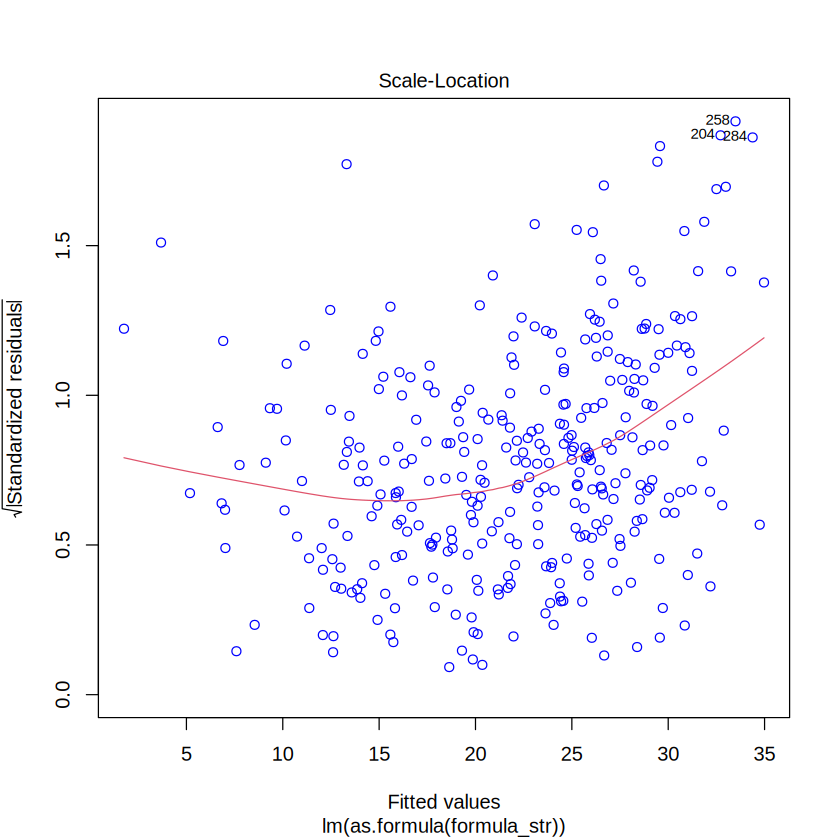

In [60]:
plot(best_model_lm, which=3, col=c("blue")) # Scale-Location

Ta phát hiện:
- Đường màu đỏ gần bị lệch về phía dưới của biểu đồ. Nghĩa là, độ phân tán của giá trị thặng dư gần không bằng nhau ở tất cả các giá trị phù hợp.
- Các giá trị thặng dư được phân tán ngẫu nhiên xung quanh đường màu đỏ với độ biến thiên không bằng nhau ở tất cả các giá trị phù hợp.

Cẩn thận hơn, chúng ta sử dụng Breusch-Pagan test để kiểm tra có thật là như vậy không?
- H0: Các giá trị thặng dư là homoscedastic
- H1: Các giá trị thặng dư là heteroscedastic

In [61]:
# Breusch-Pagan Test
bptest(best_model_lm)


	studentized Breusch-Pagan test

data:  best_model_lm
BP = 34.355, df = 3, p-value = 1.667e-07


Như vậy, ta thấy p-value bé hơn múc ý nghĩa 0.05 rất nhiều, ta chưa đủ điều kiện bác bỏ H0. Vậy các giá trị thặng dư là homoscedastic

#### Residuals vs Leverage

Biểu đồ này có thể được sử dụng để tìm các trường hợp có ảnh hưởng trong tập dữ liệu. Một trường hợp có ảnh hưởng là một trường hợp mà nếu bị loại bỏ sẽ ảnh hưởng đến mô hình nên việc đưa vào hoặc loại trừ nó cần được xem xét.

Một trường hợp có ảnh hưởng có thể là một trường hợp ngoại lệ hoặc không và mục đích của biểu đồ này là xác định các trường hợp có ảnh hưởng lớn đến mô hình. Các ngoại lệ sẽ có xu hướng có giá trị cực cao hoặc cực thấp và do đó ảnh hưởng đến mô hình.

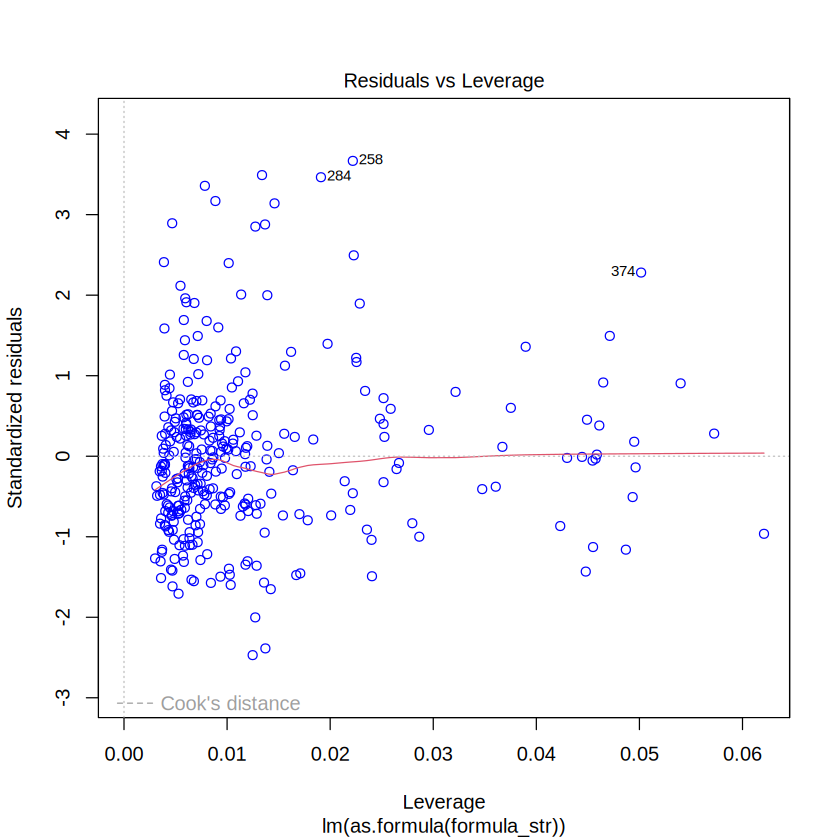

In [62]:
plot(best_model_lm, which=5, col=c("blue")) # Residuals vs Leverage

Ta nhận thấy có một số giá trị ngoại lai ở cách xa đường thằng giữa. Ta có thể xem rõ hơn thông qua histogram của Cook's Distance

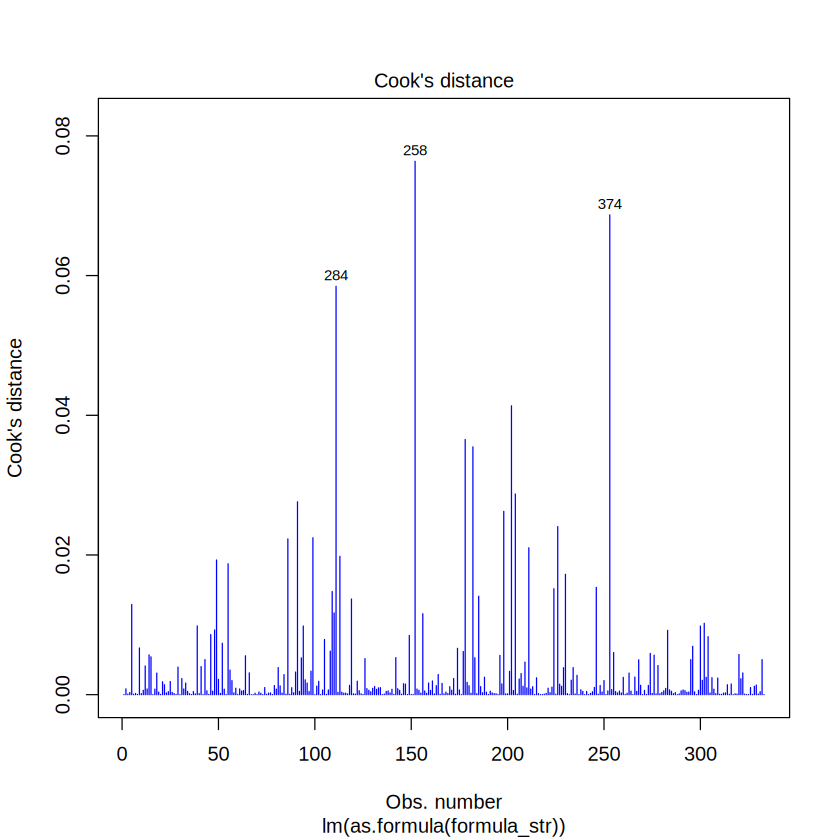

In [63]:
plot(best_model_lm, which=4, col=c("blue"))

### Dự đoán và đánh giá kết quả

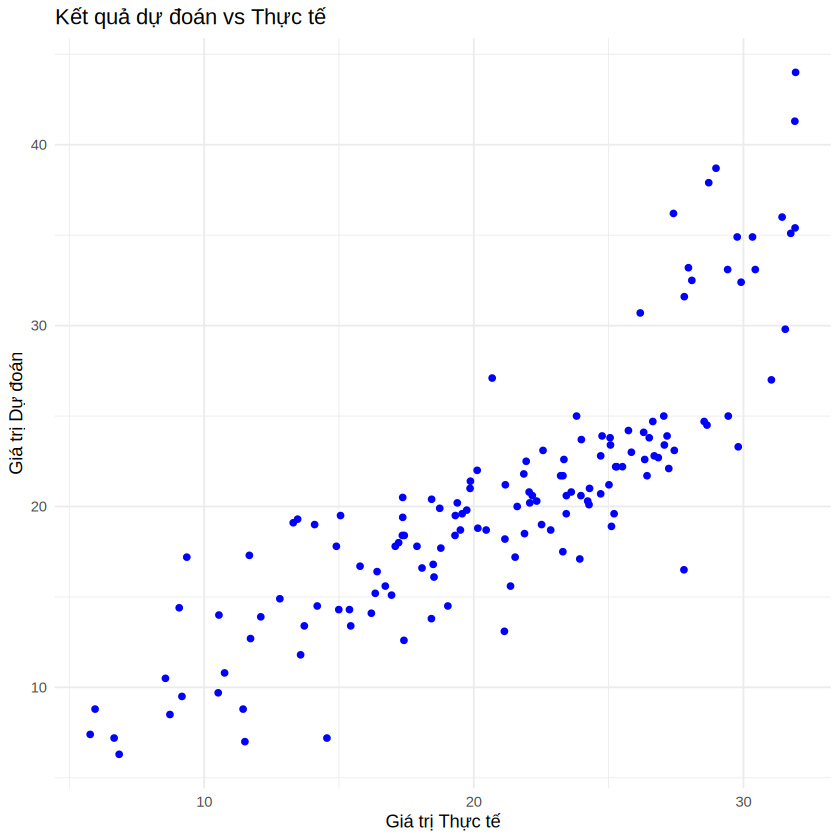

In [64]:
# predict
results <- predict(best_model_lm, test)
df <- data.frame(
    du_doan <- results,
    label <- test$medv
)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()


In [65]:
rmse(results, test$medv)

[1] 3.856846

## Đánh giá xem mô hình thu được từ step và leaps, mô hình nào tốt hơn?

Nếu từ hai phương pháp, thu được hai phương trình hồi quy khác nhau, ta sẽ kiểm định. Nếu phương trình hồi quy giống nhau, mà chỉ khác hệ số, ta có thể dựa vào RMSE.

In [66]:
print(anova(model_best, best_model_lm))

Analysis of Variance Table

Model 1: medv ~ ptratio + black + lstat
Model 2: medv ~ ptratio + black + lstat
  Res.Df    RSS Df Sum of Sq F Pr(>F)
1    329 6815.7                      
2    329 6815.7  0         0         


Ta chọn mô hình `medv ~ ptratio + black + lstat`

## Kết luận

Như vậy, thông qua quá trình mô hình hóa, ta chọ được mô hình `medv ~ ptratio + black + lstat`.

Điều này có nghĩa là khi chọn mua nhà ở Boston, khách hàng cần lưu ý các yếu tố: 
- tỷ lệ học sinh-giáo viên theo thị trấn.
- tỷ lệ người da màu
- tỷ lệ dân số có địa vị thấp hơn

Khu vực có nhiều học sinh-giáo viên và dân cư có địa vị thấp hơn thì giá nhà càng rẻ, tỷ lệ lệ người da màu cũng có ảnh hưởng nhưng không nhiều lắm.